# HOWTO estimate parameter-errors using Monte Carlo - an example with python: A practical example - 1/t decay with only six measurements
First we generate a "measured" dataset that has been perturbed from the "truth" parameters (this corresponds to our experiment). Then we fit this dataset to estimate the value of the power-law index by which y(x) decays over time. Then we use Monte-Carlo to estimate the uncertainty in this best-fit value.

![ErrorsMC_Seite_1.png](images/ErrorsMC_Seite_1.png)

![ErrorsMC_Seite_2.png](images/ErrorsMC_Seite_2.png)

First we import a few modules we'll need.

In [1]:
import pylab as P
import numpy as N
from scipy import optimize

# "Experimental" data

First we do the experiment - here we simulate the data from 1/t decay. I use uniform error for simplicity of exposition, but there's no reason we could not make things more realistic later on. Let's suppose we have a small-ish number of datapoints:

In [2]:
xMeas = N.random.uniform(0.5,3.0,size=6)
yTrue = 1.5/xMeas
sError = 0.1
yMeas = yTrue + N.random.normal(scale=sError, size=N.size(yTrue))

Let's plot this to see how our experiment looked:

(0.4, 3.0)

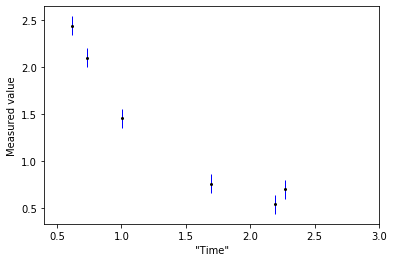

In [3]:
P.errorbar(xMeas,yMeas,yerr=sError,lw=0,elinewidth=1,ecolor='b', fmt='ko',markersize=2)
P.xlabel('"Time"')
P.ylabel('Measured value')
P.xlim(0.4,3.0)

# Fitting the data

Now we fit this data with our model. For this example, I'll assume that for whatever reason we've decided to use scipy's "curve_fit", which is pretty robust (although does not include measurement error in its fitting). No matter - the Monte Carlo will tell us what range of parameters come out under our chosen fitter.

First we define the function to fit to this data. We want to have enough free parameters to actually capture the behavior we think is going on, but not introduce redundant parameters. We also want to furnish the fitter with an initial guess, which I'll call "vGuess" below:

In [4]:
def f_decay(x,a,b):
    return a*x**(b)

We need to supply the fitter with an initial guess of the parameters. Since we'll be using the same guess for our Monte Carlo below, I'll define this as a separate element here. I'll also make the initial guess obviously "wrong" - i.e. assuming a quadratic when the underlying behavior is 1/t - to see what happens.

In [5]:
vGuess = [2.0,-2.0]

Now we run the fitter. Like many of scipy's optimization routines, the fitter needs to know (i) what function to use, (ii) the data to fit, and finally (iii) an initial guess of the parameteres. curve_fit happens to return the best-fit parameters as the first of two return-values. So we need to send those two returned values into two new variables - "vPars" will hold the returned parameters-fit.

In [6]:
vPars, aCova = optimize.curve_fit(f_decay, xMeas, yMeas, vGuess)

Now we run the fitter. Like many of scipy's optimization routines, the fitter needs to know (i) what function to use, (ii) the data to fit, and finally (iii) an initial guess of the parameteres. curve_fit happens to return the best-fit parameters as the first of two return-values. So we need to send those two returned values into two new variables - "vPars" will hold the returned parameters-fit.

In [7]:
print (vPars)

[ 1.45800253 -1.09641699]


That's not too bad - the "Truth" values were y(x) = 1.5/x and we have found y(x) = 1.46/x^(1.13). Let's take a look at what this model looks like over the data:

Text(0.5, 1.0, 'Fitted curve (green) and "truth" curve (red dashed)')

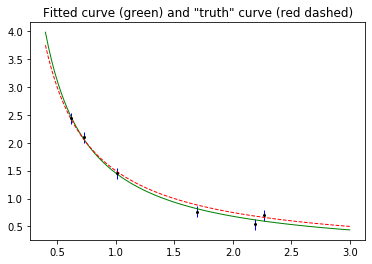

In [8]:
xFine = N.linspace(0.4,3.0,100)
P.errorbar(xMeas,yMeas,yerr=sError,lw=0,elinewidth=1,ecolor='b', fmt='ko',markersize=2)
P.plot(xFine, f_decay(xFine,*vPars), 'g-', lw=1) # Fitted parameters
P.plot(xFine, f_decay(xFine,1.5,-1.0), 'r--', lw=1) # Parameters used to generate data
P.title('Fitted curve (green) and "truth" curve (red dashed)')

# Monte Carlo - allowing observing times to vary

What we do next depends on what level we think our hypothetical experiments might differ from each other. I'll make the assumption here that the times of measurement between x=0.5 and x=3.0 were random. In that case, we would need to include this variation of measurement-time in our simulations in order to report the range of values another experimenter might find if they used a similar setup. So, we will generate a large number of datasets, re-fit the parameter values where the measurement-times are also not under our experimenter's control, and then find the range of parameters that match the data.

We need to set up a few things first: The number of trials and the combined set of best-fit parameters, for all the model parameters (initially empty). So:

In [9]:
nTrials = 4000
aFitPars = N.array([])

Now we actually do the simulations. Each time we need to generate the data as well as fit it.

(There is one syntax complication: we cannot stack a 1d vector onto an empty array in python, so there is an if/then for the FitPars array: if it's empty, copy the latest round of fitted parameters into it, if not then stack the latest round of fitted parameters onto what we have so far.)

In [10]:
for iTrial in range(nTrials):
    xTrial = N.random.uniform(0.5,3.0,size=N.size(xMeas))
    yGen = 1.5/xTrial
    yTrial = yGen + N.random.normal(scale=sError,size=N.size(yGen))
    # We use a try/except clause to catch pathologies
    try:
        vTrial, aCova = optimize.curve_fit(f_decay,xTrial,yTrial,vGuess)
    except:
        dumdum=1
        continue  # This moves us to the next loop without stacking.
    
    #here follows the syntax for stacking the trial onto the running sample:
    if N.size(aFitPars) < 1:
        aFitPars=N.copy(vTrial)
    else:
        aFitPars = N.vstack(( aFitPars, vTrial ))
print (aFitPars)

[[ 1.57108044 -0.85908804]
 [ 1.45368338 -0.92564522]
 [ 1.56362866 -1.04870361]
 ...
 [ 1.64558487 -1.16819191]
 [ 1.4745234  -0.85998504]
 [ 1.47423094 -1.00982355]]




A couple of points to note in the above chunk:

    All those N.size() calls are to ensure that the various arrays are consistent with the size of the measured data. We could equally well have typed "6" in most of those places, but then we'd have to change it each time a new experiment was done with different numbers of datapoints. Also,

    Your fitting routine might sometimes not work. A more sophisticated analysis would catch these errors: here I'm just using python's "try/except" clause to gracefully ignore the bad cases. (If you're finding that more than a percent or so of cases are breaking, you may want to double-check whether your model has too few or too many parameters for the data). Finally:

    In this example, I am starting with an empty aFitPars array and then stacking on the fit-values only if the fitting routine ran without failing. The "continue" statement stops the routine from dumbly stacking on the last fit-value if the fit failed. I do things this way so that the fitpars array is always the correct size to match the number of correctly-run trials.

Having done all that, let's look at the size of the set of trials:

In [11]:
N.shape(aFitPars)

(4000, 2)

This shows that all our 4000 trials were successful, which isn't too bad. Now, let's look at the distribution of powers of x that came out of the fit:

In [12]:
print (N.median (aFitPars[:,1]))
print (N.std (aFitPars[:,1]))

-1.0019933547856383
0.1336587123931181


Let's take a graphical look at this parameter. We'll use matplotlib's "hist" feature to generate and plot the distribution for convenience, but there are other better tools you'll likely come across.

0.1336587123931181


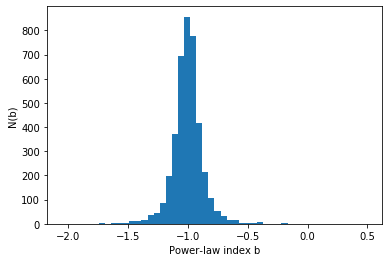

In [13]:
P.hist(aFitPars[:,1],bins=50)
P.xlabel('Power-law index b')
P.ylabel('N(b)')

print (N.std(aFitPars[:,1]))

We see that the standard deviation of our fitted parameter is pretty high - our measurement of (constant/(x^{1.13})) is more accurately (constant/(x^{1.13 +- 0.138}\)). This is consistent with 1/x within the range of values we have recovered.

Notice also that our 1D distribution looks nice and gaussian. But is the situation really this simple? Let's look at both power-law components together:

Text(0, 0.5, 'Power-law index b')

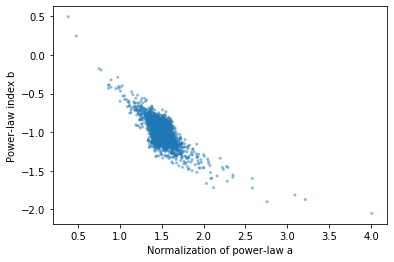

In [14]:
P.scatter(aFitPars[:,0], aFitPars[:,1], alpha=0.5, s=9, edgecolor='none')
P.xlabel('Normalization of power-law a')
P.ylabel('Power-law index b')

Here follows a little bit of matplotlib voodoo to show this in a slightly more visually appealing way:

Text(0, 0.5, 'Power-law index b')

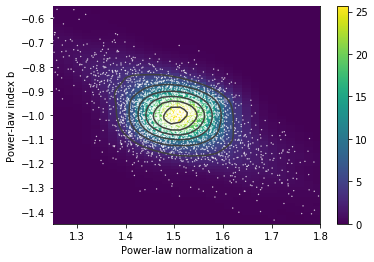

In [15]:
from scipy.stats import kde
x,y=aFitPars.T

# Use a kernel density estimator to produce local-counts in this space, and grid them to plot.
k = kde.gaussian_kde(aFitPars.T)
nbins=200
xi, yi = N.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(N.vstack([xi.flatten(), yi.flatten()]))

# Show the density
P.pcolormesh(xi, yi, zi.reshape(xi.shape), zorder=3)
P.colorbar()

# Show the datapoints on top of this, and also the contours. "zorder" sets the vertical order in the plot.
P.scatter(aFitPars[:,0], aFitPars[:,1], c='w', s=2, zorder=15, edgecolor='none',alpha=0.75)
P.contour(xi,yi,zi.reshape(xi.shape), zorder=25, colors='0.25')


P.ylim(-1.45,-0.55)
P.xlim(1.25,1.80)
P.xlabel('Power-law normalization a')
P.ylabel('Power-law index b')

Even in our simple two-parameter problem the results are quite interesting. For example, the correlation between parameters appears to switch sign the farther from the center of the cloud we go - perhaps indicating different regimes depending on the clustering of measurement-times.

# Were our observing times special?

Now suppose instead that we had good reason to make measurements at the times (x-values) that we did. Perhaps a realistic estimate for the errors should not allow the measurement times to vary.

Let's try another Monte-Carlo, this time asking what parameter values we recover if we make identical experiments at the same times as our real data, but still subject to experimental error at those times:


In [16]:
aFitSameTimes=N.array([])
for iTrial in range(nTrials):
    yGen = 1.5/xMeas  # Same measured times this time!
    yTrial = yGen + N.random.normal(scale=sError,size=N.size(yGen))
    
    # We use a try/except clause to catch pathologies
    try:
        vTrial, aCova = optimize.curve_fit(f_decay,xMeas,yTrial,vGuess)
    except:
        dumdum=1
        continue  # This moves us to the next loop without stacking.
        
    #here follows the syntax for stacking the trial onto the running sample:
    if N.size(aFitSameTimes) < 1:
        aFitSameTimes=N.copy(vTrial)
    else:
        aFitSameTimes = N.vstack(( aFitSameTimes, vTrial ))

Let's look at the spread in recovered values as we did before:

Text(0.5, 1.0, 'Same measurement times each trial')

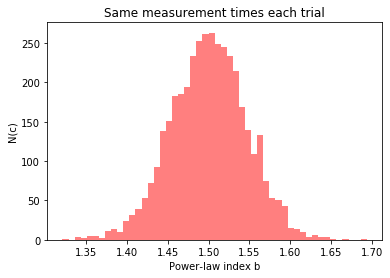

In [17]:
P.hist(aFitSameTimes[:,0],bins=50, alpha=0.5,color='r')
P.xlabel('Power-law index b')
P.ylabel('N(c)')
P.title('Same measurement times each trial')

In [18]:
print (N.median(aFitSameTimes[:,1]))
print (N.std(aFitSameTimes[:,1]))

-1.0007344622288739
0.07139096665073807


Let's look at those parameters plotted against each other as we did before.

Text(0.5, 1.0, 'Same measurement times each trial')

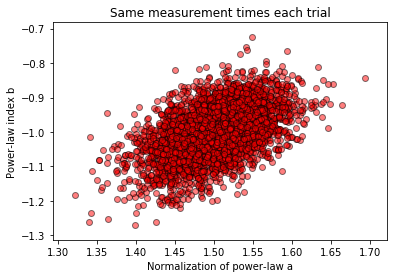

In [19]:
P.scatter(aFitSameTimes[:,0], aFitSameTimes[:,1],c='r', s=36, edgecolor='k', alpha=0.5)
P.xlabel('Normalization of power-law a')
P.ylabel('Power-law index b')
P.title('Same measurement times each trial')

# Set the same axis-ranges as above for visual comparison
#P.xlim(1.30, 1.70)
#P.ylim(-1.4,-0.6)

As we might expect, the measurements are still correlated, but the distribution is tighter. Let's take a look at the two sets of parameters on top of each other:

Text(0.5, 1.0, 'Random observing times (blue) and frozen times (red)')

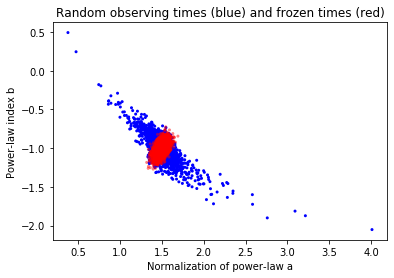

In [20]:
# the alpha values below are transparency values for plots.
P.scatter(aFitSameTimes[:,0], aFitSameTimes[:,1],c='r', s=9, edgecolor='none', zorder=25, alpha=0.5)
P.scatter(aFitPars[:,0], aFitPars[:,1],c='b', s=9, edgecolor='none', zorder=5)

P.xlabel('Normalization of power-law a')
P.ylabel('Power-law index b')
P.title('Random observing times (blue) and frozen times (red)')

Or we can generate our contours and compare the two sets visually:

C:\Users\Ralf\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The following kwargs were not used by contour: 'lw'
  


Text(0, 0.5, 'Power-law index b')

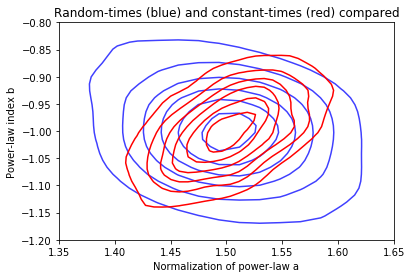

In [21]:
xS,yS=aFitSameTimes.T
kS = kde.gaussian_kde(aFitSameTimes.T)
nbins=50
xiS, yiS = N.mgrid[xS.min():xS.max():nbins*1j, yS.min():yS.max():nbins*1j]
ziS = kS(N.vstack([xiS.flatten(), yiS.flatten()]))

# Now let's plot this over the previous (xi,yi,zi) case:
P.contour(xi,yi,zi.reshape(xi.shape),colors='b',lw=2, zorder=5, alpha=0.75)
P.contour(xiS, yiS, ziS.reshape(xiS.shape), colors='r', zorder=15, alpha=1.0)

P.xlim(1.35,1.65)
P.ylim(-1.20,-0.80)
P.title('Random-times (blue) and constant-times (red) compared')

P.xlabel('Normalization of power-law a')
P.ylabel('Power-law index b')

# Discussion



So, which value for the spread of the power-law index "b" should we use in our hypothetical publication?

That depends on which of the scenarios simulated you believe to be the most honest representation of the differences between predicted and actual data one would encounter in real life. What you CANNOT do is just pick the scenario that gives the smallest range just because you want to report the smaller error!

It's usually best to be as upfront as possible about what your errors mean. This is where in your paper you would report not just the range, but also under what circumstances this was estimated. If you assumed your measurement times were constant when making the monte carlo, then say so - and you should also justify in the paper why you made this assumption. In this simple case above, the differences between assuming any set of random times (blue) and the exact times (red) is not very large, but you still want the reader to understand as much as possible about your data.

In most cases - even the simple toy problem here - you should really go one better, and give the reader not just the range of values consistent with your data, but the full likelihood function of the fitted parameters. This is usually hard to parameterise but easy to show - just show the graph of the recovered parameters (any of the example graphs above would be good)!

Notice also that in the case of the toy problem here, even a two-parameter model with a very simple form has led to real covariance between the fitted parameters under our monte carlo experiments. Under this situation, what would the 1-sigma variation in one of the parameters mean?

In a situation like this, you can easily report not just the standard deviation (or its square, the variance) but instead the Covariance of the parameters. The diagonal elements are the variance of each parameter, while the off-diagonals indicate the covariance between each pair of parameters. In python, this is easy:

In [22]:
aCovFit = N.cov(N.transpose(aFitSameTimes))

Looking at the resulting covariance matrix, we see that - like our graphs above suggest - the two parameters do indeed vary together:

In [23]:
print (aCovFit)

[[0.00213236 0.00165494]
 [0.00165494 0.00509794]]


In [24]:
print (N.std(aFitPars[:,0]))
print (N.sqrt(aCovFit[0,0]))

0.12763775640064384
0.04617751165321597


That difference between the diagonal element and the standard deviation of the fitted parameter "a" is small but significant! It means there is a nonzero covariance. We can get a little bit more insight by computing the normalized covariance (the correlation). We see that the off-diagonal terms are about 55 percent of the diagonal terms (expressed as variance not standard deviation).

In [25]:
N.corrcoef(N.transpose(aFitSameTimes))

array([[1.        , 0.50194287],
       [0.50194287, 1.        ]])

If you're more familiar with the standard deviation rather than the variance, you might take the square root to get a visual handle on how large this correlation is, remembering to use the absolute value in case of negative off-diagonal terms (which we'd get in the case of variables anti-correlated with each other).

In [26]:
N.sqrt(N.abs(N.corrcoef(N.transpose(aFitSameTimes))))

array([[1.        , 0.70847927],
       [0.70847927, 1.        ]])